In [1]:
import os
import random
import h5py
import numpy as np
import pandas as pd
import scipy as sp
import scanpy as sc
import matplotlib.pyplot as plt
from scvi.dataset import AnnDatasetFromAnnData
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import scanpy as sc
import anndata
import torch

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

%matplotlib inline 

# Sets torch and numpy random seeds, run after all scvi imports
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 

/data/xiong/anaconda3/envs/scVIC/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def getNClusters(data, n_cluster, range_min=0, range_max=4, max_steps=20, verbose=False):
    if isinstance(data, np.ndarray):
        data = anndata.AnnData(X=data)
    assert isinstance(data, anndata.AnnData), \
        "data must be numpy.ndarray or anndata.AnnData"
    this_min = range_min
    this_max = range_max
    for this_step in range(max_steps):
        if verbose:
            print("step: " + str(this_step))
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.pp.neighbors(data)
        sc.tl.louvain(data, resolution=this_resolution)
        this_clusters = len(np.unique(data.obs['louvain']))
        if verbose:
            print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
        if this_clusters > n_cluster:
            this_max = this_resolution
        if this_clusters < n_cluster:
            this_min = this_resolution
        if this_clusters == n_cluster:
            if not verbose:
                print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
            return data
    print('Cannot find the number of clusters')

In [3]:
h5_path = "../Datasets/Extracted_h5_Datasets/Tosches_turtle/data.h5"

class dotdict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def empty_safe(fn, dtype):
    def _fn(x):
        if x.size:
            return fn(x)
        return x.astype(dtype)
    return _fn

decode = empty_safe(np.vectorize(lambda _x: _x.decode("utf-8")), str)

def read_clean(data):
    assert isinstance(data, np.ndarray)
    if data.dtype.type is np.bytes_:
        data = decode(data)
    if data.size == 1:
        data = data.flat[0]
    return data

def dict_from_group(group):
    assert isinstance(group, h5py.Group)
    d = dotdict()
    for key in group:
        if isinstance(group[key], h5py.Group):
            value = dict_from_group(group[key])
        else:
            value = read_clean(group[key][...])
        d[key] = value
    return d

def read_data(filename, sparsify = False, skip_exprs = False):
    with h5py.File(filename, "r") as f:
        obs = pd.DataFrame(dict_from_group(f["obs"]), index = decode(f["obs_names"][...]))
        var = pd.DataFrame(dict_from_group(f["var"]), index = decode(f["var_names"][...]))
        uns = dict_from_group(f["uns"])
        if not skip_exprs:
            exprs_handle = f["exprs"]
            if isinstance(exprs_handle, h5py.Group):
                mat = sp.sparse.csr_matrix((exprs_handle["data"][...], exprs_handle["indices"][...],
                                               exprs_handle["indptr"][...]), shape = exprs_handle["shape"][...])
            else:
                mat = exprs_handle[...].astype(np.float32)
                if sparsify:
                    mat = sp.sparse.csr_matrix(mat)
        else:
            mat = sp.sparse.csr_matrix((obs.shape[0], var.shape[0]))
    return mat, obs, var, uns

mat, obs, var, uns = read_data(h5_path, sparsify=False, skip_exprs=False)

if isinstance(mat, np.ndarray):
    X = np.array(mat)
else:
    X = np.array(mat.toarray())
X = np.ceil(X).astype(np.int)    
cell_name = np.array(obs["cell_type1"])
adata = sc.AnnData(X)
adata.obs['cell_types'] = cell_name

In [4]:
turtle_dataset = AnnDatasetFromAnnData(adata)
turtle_dataset.subsample_genes(1000)
turtle_dataset.make_gene_names_lower()

[2022-09-18 07:21:11,859] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2022-09-18 07:21:11,862] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2022-09-18 07:21:18,928] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-09-18 07:21:19,743] INFO - scvi.dataset.dataset | Downsampled from 18664 to 18664 cells
[2022-09-18 07:21:19,755] INFO - scvi.dataset.dataset | extracting highly variable genes using seurat_v3 flavor
[2022-09-18 07:21:30,369] INFO - scvi.dataset.dataset | Downsampling from 23500 to 1000 genes
[2022-09-18 07:21:30,871] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-09-18 07:21:30,931] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2022-09-18 07:21:31,315] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2022-09-18 07:21:31,351] INFO - scvi.dataset.dataset | Downsampled from 18664 to 18664 cells
[2022-09-18 07:21:31,352] INFO - scvi.dataset.d

In [5]:
n_epochs = 400
lr = 0.001
use_cuda = True
use_batches = False

In [6]:
turtle_vae = VAE(turtle_dataset.nb_genes, n_batch=turtle_dataset.n_batches * use_batches)
trainer = UnsupervisedTrainer(
    turtle_vae,
    turtle_dataset,
    train_size=1.0,
    use_cuda=use_cuda
)

trainer.train(n_epochs=n_epochs, lr=lr)

[2022-09-18 07:21:41,202] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|███████████████████████████████| 400/400 [28:26<00:00,  4.27s/it]


In [7]:
full = trainer.create_posterior(trainer.model, turtle_dataset, indices=np.arange(len(turtle_dataset)))
# Updating the "minibatch" size after training is useful in low memory configurations
full = full.update({"batch_size":32})
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
data = getNClusters(latent, n_cluster=turtle_dataset.n_labels)
labels_pred = data.obs["louvain"].astype(int)

got 15 at resolution 0.5


In [8]:
post_adata = anndata.AnnData(X=turtle_dataset.X)
post_adata.obsm["X_scVI"] = latent
post_adata.obs['cell_type'] = np.array([turtle_dataset.cell_types[turtle_dataset.labels[i][0]]  
                                        for i in range(post_adata.n_obs)])
labels_pred=pd.Series(labels_pred, index=post_adata.obs.index, dtype='category')
labels_pred.cat.categories=list(range(len(labels_pred.unique())))
post_adata.obs['predicted_type'] = labels_pred
sc.pp.neighbors(post_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.3)
show_plot = True

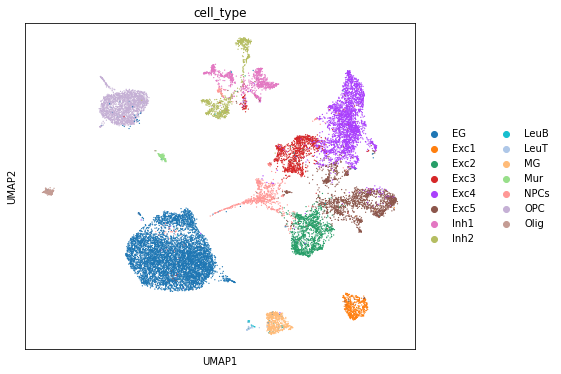

In [9]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax, show=show_plot)

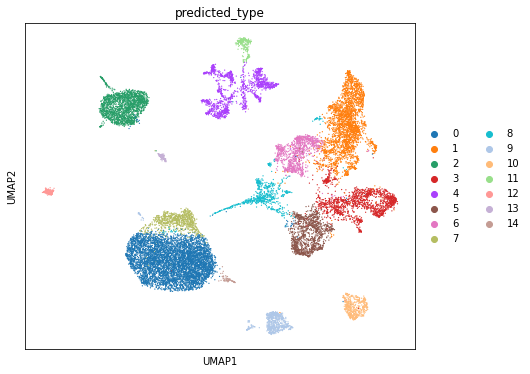

In [10]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["predicted_type"], ax=ax, show=show_plot)

In [11]:
ARI = np.around(adjusted_rand_score(turtle_dataset.labels.squeeze(), labels_pred), 5)
print("Turtle_scVI_Louvain_ARI: ")
print(ARI)
NMI = np.around(normalized_mutual_info_score(turtle_dataset.labels.squeeze(), labels_pred, average_method='arithmetic'), 5)
print("Turtle_scVI_Louvain_NMI: ")
print(NMI)        

Turtle_scVI_Louvain_ARI: 
0.82207
Turtle_scVI_Louvain_NMI: 
0.84559


In [12]:
saved_data = anndata.AnnData(X=latent)
saved_data.obs['cell_type'] = post_adata.obs['cell_type']
saved_data.obs['predicted_type'] = post_adata.obs['predicted_type']
saved_data.obsm["default_visualization"] = post_adata.obsm["X_umap"]
saved_data.uns["ari"] = ARI
saved_data.uns["nmi"] = NMI
saved_data.uns["default_visualization_method"] = 'umap'
saved_data.write_h5ad("../Saved_Data/scVI_Louvain/Turtle_scVI_Louvain.h5")